In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:

df = pd.read_csv('data.csv')

df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,75682867,Female,No,0,Graduate,Yes,2500,0.0,93.0,360.0,NaN,Urban,Y
1,66755036,Male,Yes,2,Not Graduate,No,6125,1625.0,187.0,480.0,1.0,Semiurban,N
2,66882282,Male,Yes,0,Graduate,No,2768,1950.0,155.0,360.0,1.0,Rural,Y
3,31081788,Female,Yes,0,Graduate,No,4583,0.0,112.0,360.0,1.0,Rural,N
4,23315092,Male,No,0,Graduate,Yes,10416,0.0,187.0,360.0,0.0,Urban,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,10448345,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,Y
610,86246546,Female,Yes,0,Graduate,No,2330,4486.0,100.0,360.0,1.0,Semiurban,Y
611,84936358,Male,Yes,2,Graduate,No,3073,8106.0,200.0,360.0,1.0,Urban,Y
612,25814828,Male,Yes,1,Graduate,Yes,1000,3022.0,110.0,360.0,1.0,Urban,N


In [3]:

df.shape

(614, 13)

In [4]:

df.describe()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,6.140000e+02,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5.503383e+07,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,2.600821e+07,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,1.006109e+07,150.000000,0.000000,9.000000,12.00000,0.000000
25%,3.279267e+07,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,5.626877e+07,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,7.721024e+07,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,9.996661e+07,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    int64  
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ KB


In [6]:
# Check the number of missing values
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

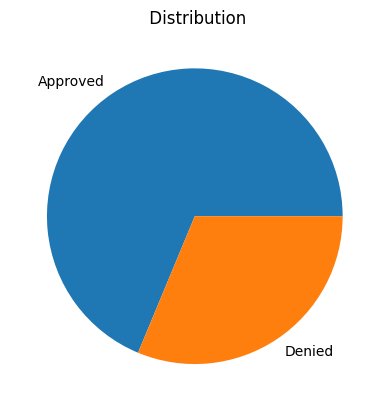

In [7]:
# Visualize the balance of loan approvals to see if we will need to fix any imbalance
plt.pie(df['Loan_Status'].value_counts().values, labels=['Approved', 'Denied'])
plt.title(' Distribution')
plt.show()

In [8]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

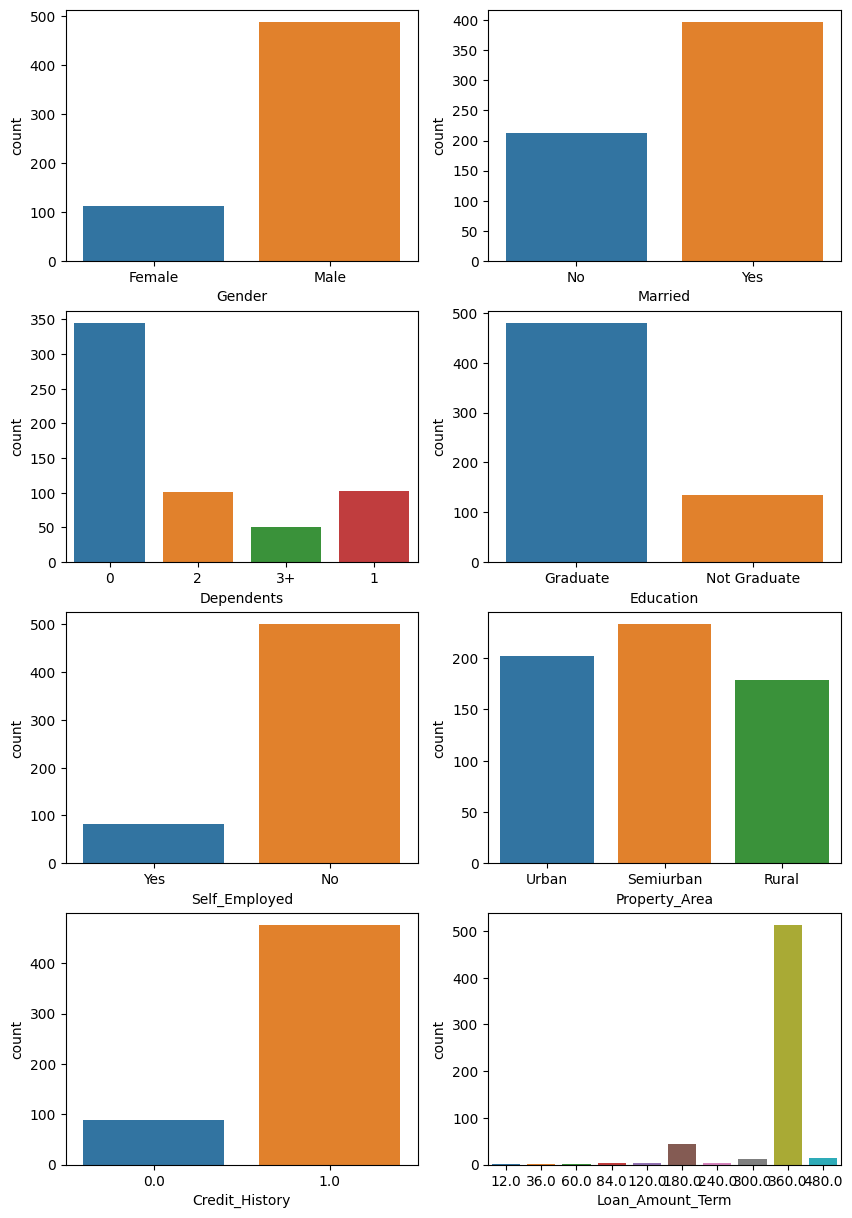

In [9]:
plt.figure(figsize=(10,15))

index = 1
for col in categorical_cols[:6]+['Credit_History', 'Loan_Amount_Term']:
    plt.subplot(4,2,index)
    sns.countplot(data=df, x=col)
    index = index + 1
plt.show()

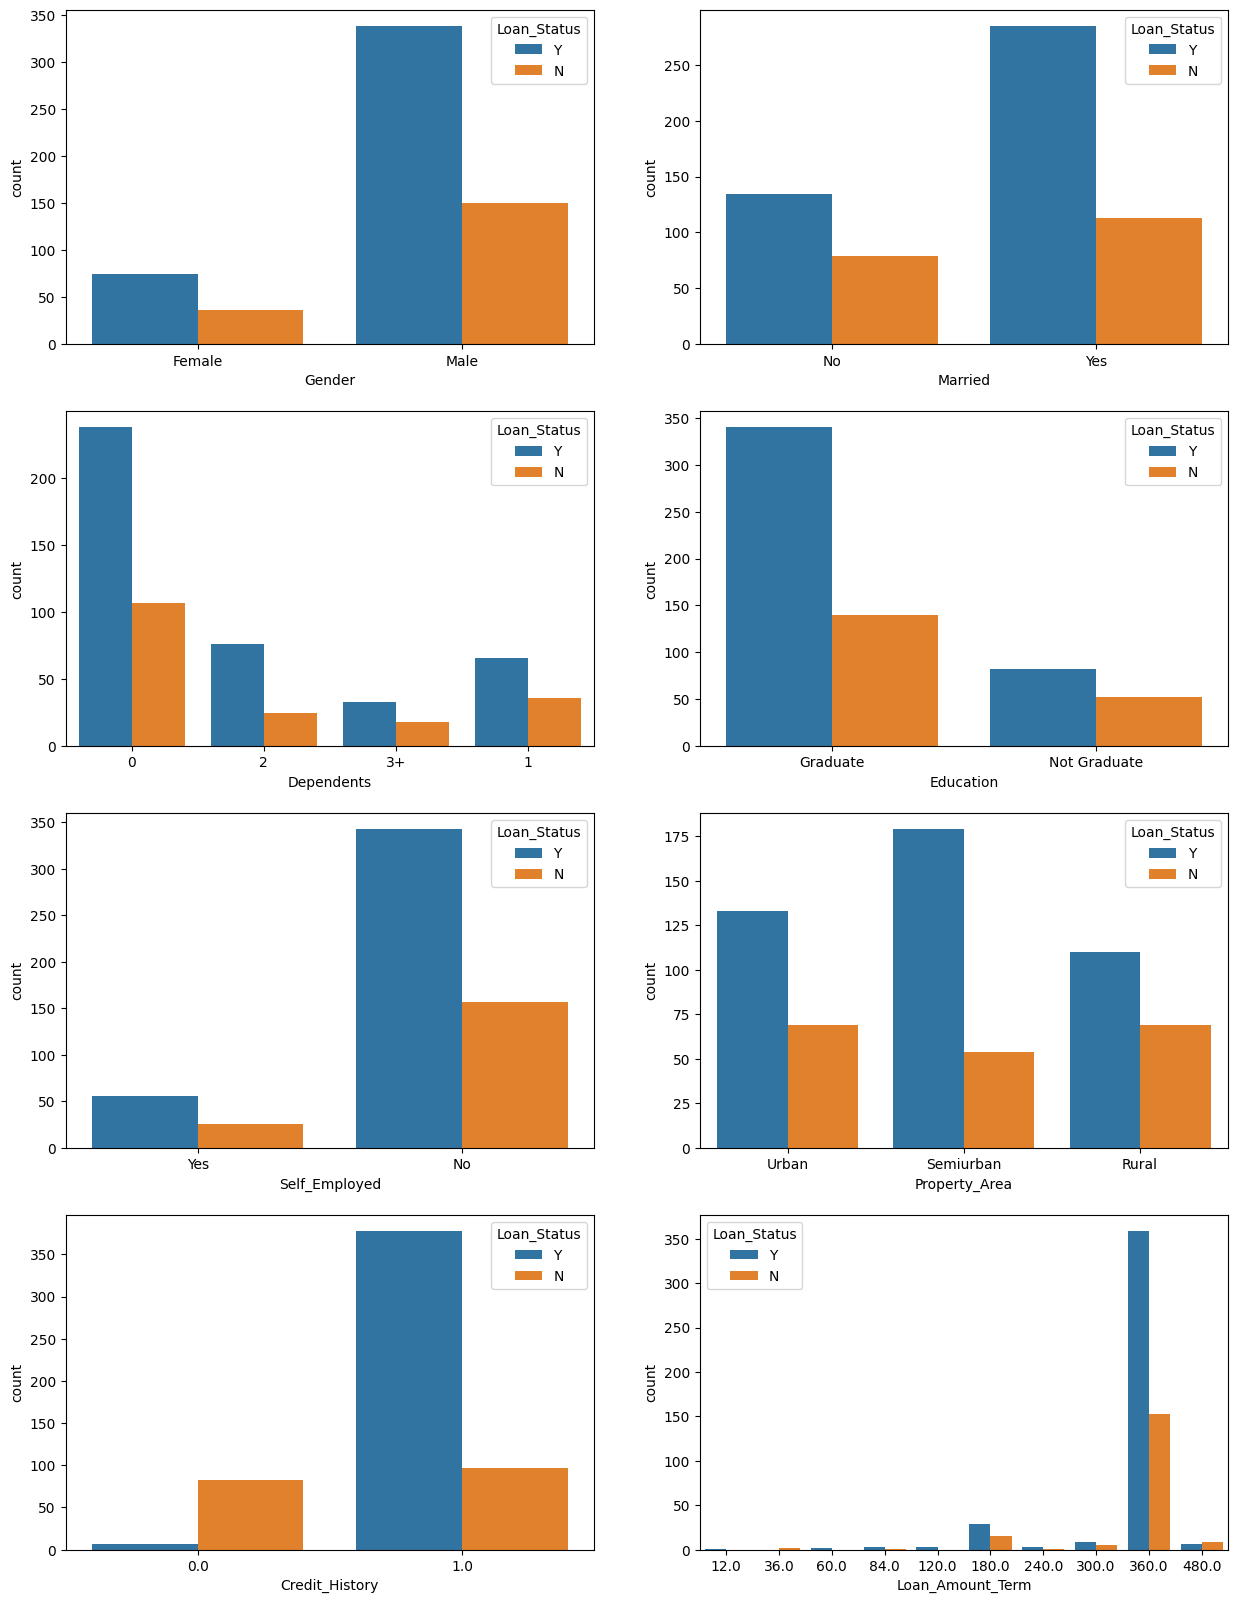

In [10]:
plt.figure(figsize=(15,20))

index = 1
for col in categorical_cols[:6]+['Credit_History', 'Loan_Amount_Term']:
    plt.subplot(4,2,index)
    sns.countplot(data=df, x=col, hue='Loan_Status')
    index = index + 1
plt.show()

In [11]:
# Drop the Loan ID 
df = df.drop(['Loan_ID'], axis = 1)

# Remove missing credit history entries from the dataset
df = df[df['Credit_History'].notnull()]

# Loan amount should be filled with the average loan amount
df['LoanAmount'] = df['LoanAmount'].fillna(df.LoanAmount.mean())

# Fill missing data using the most common variable
df['Gender'] = df['Gender'].fillna(df.Gender.mode()[0])
df['Married'] = df['Married'].fillna(df.Married.mode()[0])
df['Dependents'] = df['Dependents'].fillna(df.Dependents.mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df.Self_Employed.mode()[0])
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df.Loan_Amount_Term.mode()[0])

# Check the number of null values per column
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [12]:
# Print categorical columns that need to be encoded
for col in categorical_cols:
    print(df[col].value_counts(), '\n')

Gender
Male      463
Female    101
Name: count, dtype: int64 

Married
Yes    365
No     199
Name: count, dtype: int64 

Dependents
0     331
2      95
1      90
3+     48
Name: count, dtype: int64 

Education
Graduate        443
Not Graduate    121
Name: count, dtype: int64 

Self_Employed
No     489
Yes     75
Name: count, dtype: int64 

Property_Area
Semiurban    217
Urban        182
Rural        165
Name: count, dtype: int64 

Loan_Status
Y    385
N    179
Name: count, dtype: int64 



In [13]:


# Label encoding, where categorical columns are encoded to be numerical.
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
    print(df[col].value_counts(), "\n")

Gender
1    463
0    101
Name: count, dtype: int64 

Married
1    365
0    199
Name: count, dtype: int64 

Dependents
0    331
2     95
1     90
3     48
Name: count, dtype: int64 

Education
0    443
1    121
Name: count, dtype: int64 

Self_Employed
0    489
1     75
Name: count, dtype: int64 

Property_Area
1    217
2    182
0    165
Name: count, dtype: int64 

Loan_Status
1    385
0    179
Name: count, dtype: int64 



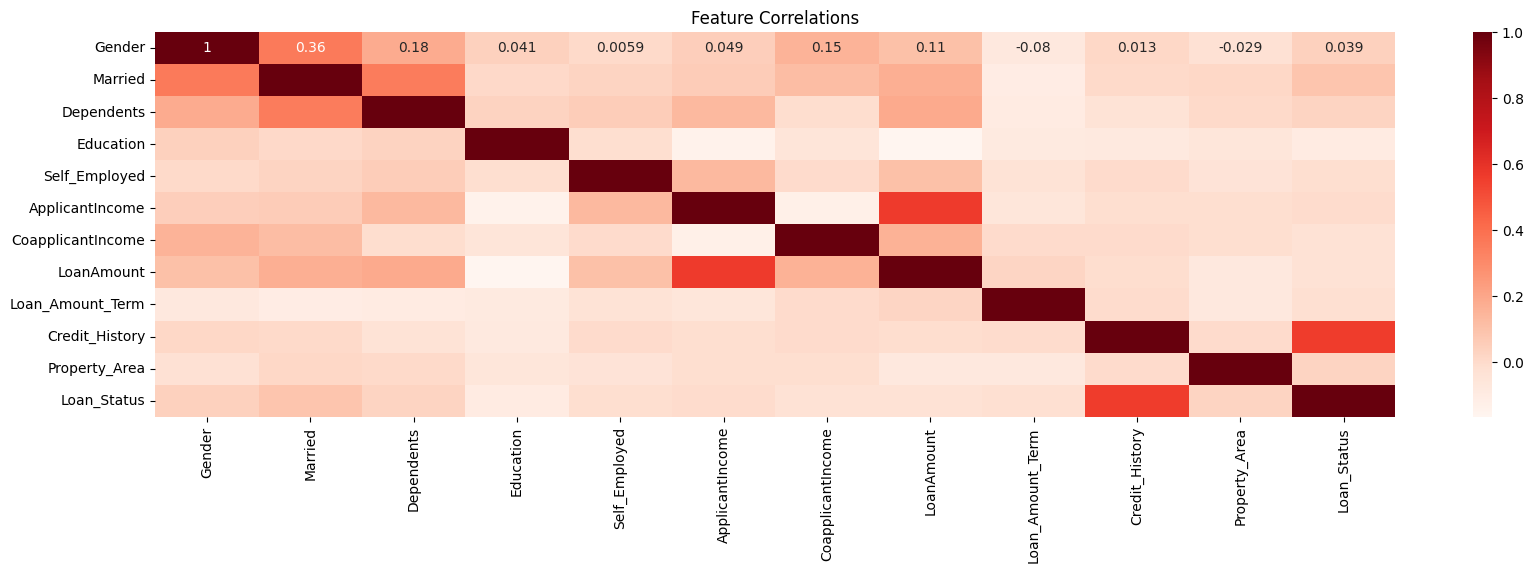

In [14]:
# Visualize feature correlations in a heatmap
plt.subplots(figsize=(20, 5))
sns.heatmap(df.corr(), annot=True, cmap='Reds')
plt.title('Feature Correlations')
plt.show()

In [15]:
# Set up the feature and target datasets
X = df.drop(['Loan_Status'], axis=1).values
y = df['Loan_Status'].values

X

array([[  1.,   1.,   2., ..., 480.,   1.,   1.],
       [  1.,   1.,   0., ..., 360.,   1.,   0.],
       [  0.,   1.,   0., ..., 360.,   1.,   0.],
       ...,
       [  1.,   1.,   2., ..., 360.,   1.,   2.],
       [  1.,   1.,   1., ..., 360.,   1.,   2.],
       [  1.,   0.,   0., ..., 360.,   1.,   1.]])

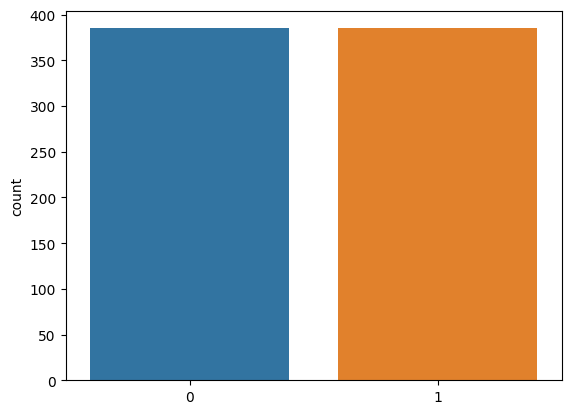

In [16]:
# Balance the data by oversampling
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)

# Visualize the new balance
sns.countplot(x=y)
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Normalize the data with scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(577, 11) (193, 11) (577,) (193,)


In [18]:
def fit_and_eval(model):

    # Fit the model with the training datasets
    model.fit(X_train, y_train)

    # Predict labels for X_test samples
    y_pred = model.predict(X_test)

    # Capture model metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)

    # Capture cross validation score unless the model is GridSearchCV, as it performs cross-validation
    if model.__class__.__name__ != 'GridSearchCV':
        cv_score = cross_val_score(model, X, y, cv=5)
        mean_cv_score = cv_score.mean()

    # Output model metrics
    print('Metrics for {}:'.format(model.__class__.__name__))
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1 Score: {}'.format(f1))
    print('ROC AUC Score: {}'.format(roc_score))

    # Skip over cross validation for GridSearchCV as it is automatically performed
    if model.__class__.__name__ != 'GridSearchCV':
        print('Mean CV Accuracy: {}'.format(mean_cv_score))

    # Output the classification report
    print('\nClassification Report:\n', classification_report(y_test, y_pred))

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, cbar=True, linewidths=.5)
    plt.title(f'Confusion Matrix Heatmap for {model.__class__.__name__}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

    # Transform the accuracy to a percentage for output
    accuracy = round((accuracy * 100), 2)

    return model, accuracy

Metrics for LogisticRegression:
Accuracy: 0.7046632124352331
Precision: 0.6370967741935484
Recall: 0.8681318681318682
F1 Score: 0.7348837209302326
ROC AUC Score: 0.7134776987718164
Mean CV Accuracy: 0.7454545454545455

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67       102
           1       0.64      0.87      0.73        91

    accuracy                           0.70       193
   macro avg       0.73      0.71      0.70       193
weighted avg       0.74      0.70      0.70       193



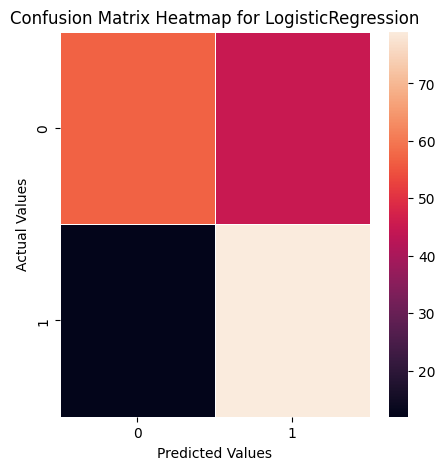


Metrics for RandomForestClassifier:
Accuracy: 0.8134715025906736
Precision: 0.7570093457943925
Recall: 0.8901098901098901
F1 Score: 0.8181818181818181
ROC AUC Score: 0.8176039646627882
Mean CV Accuracy: 0.9103896103896103

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81       102
           1       0.76      0.89      0.82        91

    accuracy                           0.81       193
   macro avg       0.82      0.82      0.81       193
weighted avg       0.82      0.81      0.81       193



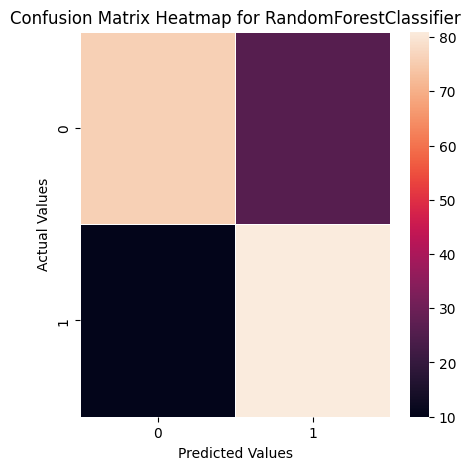


Metrics for SVC:
Accuracy: 0.7409326424870466
Precision: 0.664
Recall: 0.9120879120879121
F1 Score: 0.7685185185185185
ROC AUC Score: 0.7501616031027796
Mean CV Accuracy: 0.5233766233766233

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.59      0.71       102
           1       0.66      0.91      0.77        91

    accuracy                           0.74       193
   macro avg       0.77      0.75      0.74       193
weighted avg       0.78      0.74      0.74       193



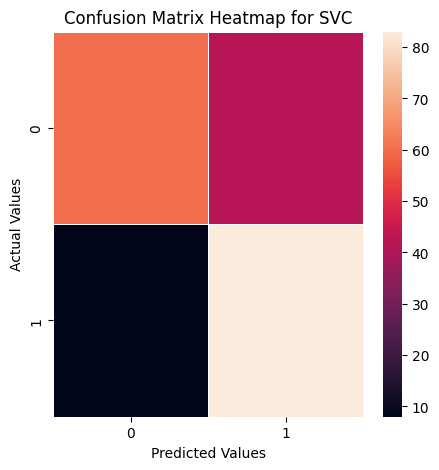

In [19]:
# Define the algorithms that are to be evaluated
algorithms = {
    'lr':  LogisticRegression(random_state=0, max_iter=500),
    'rfc': RandomForestClassifier(random_state=0),
    'svc': SVC(random_state=0, kernel='rbf')
}

# Define dictionaries for classifiers and accuracies
clfs = {}
accuracies = {}

for algo in algorithms:
    # Fit and evaluate classifiers and accuracies
    clfs[algo], accuracies[algo] = fit_and_eval(algorithms[algo])

    # Adds a space between algorithm outputs
    if algo != 'svc':
        print()

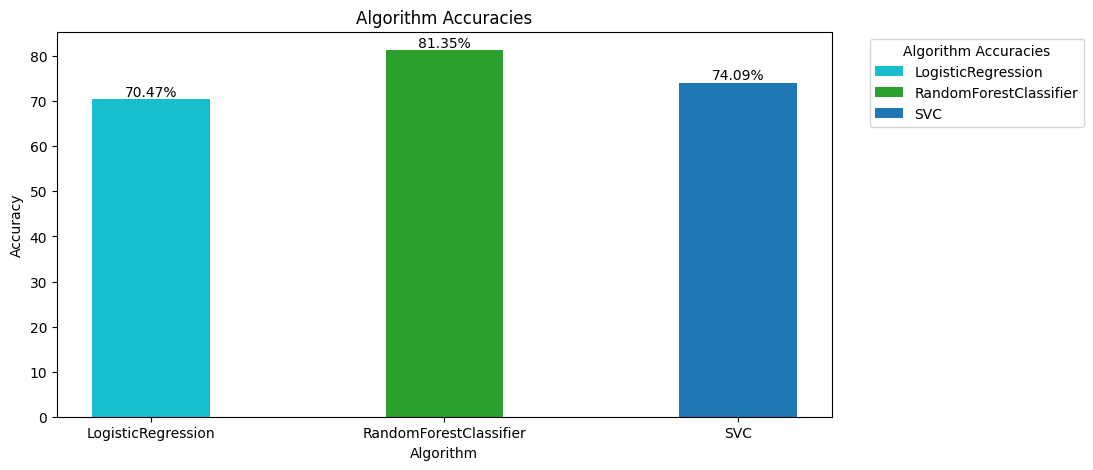

In [20]:
# Initialize the labels and values for the comparison graph
labels = [clf.__class__.__name__ for clf in clfs.values()]
values = accuracies.values()

# Set styling variables
label_colors = ['cyan', 'green', 'blue']
bar_colors = ['tab:cyan', 'tab:green', 'tab:blue']

# Define figure and axes objects
fig, ax = plt.subplots(figsize=(10, 5))

# Create a list of bar plots for the graph
bars = ax.bar(labels, values, label=label_colors, color=bar_colors, width=0.4)

# Style the graph
ax.set_xlabel('Algorithm')
ax.set_ylabel('Accuracy')
ax.set_title('Algorithm Accuracies')
ax.legend(title='Algorithm Accuracies', labels=labels, bbox_to_anchor=(1.04, 1), loc='upper left')

# Iterate over the bars to add percentages above them
for bar in bars:
    pos_x = bar.get_x() + bar.get_width() / 2.0
    pos_y = bar.get_height()
    str = f'{pos_y:.2f}%'
    plt.text(pos_x, pos_y, str, ha='center', va='bottom')

# Display the bar graph
plt.show()

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Metrics for GridSearchCV:
Accuracy: 0.8134715025906736
Precision: 0.7522935779816514
Recall: 0.9010989010989011
F1 Score: 0.8200000000000001
ROC AUC Score: 0.81819650937298

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81       102
           1       0.75      0.90      0.82        91

    accuracy                           0.81       193
   macro avg       0.82      0.82      0.81       193
weighted avg       0.83      0.81      0.81       193



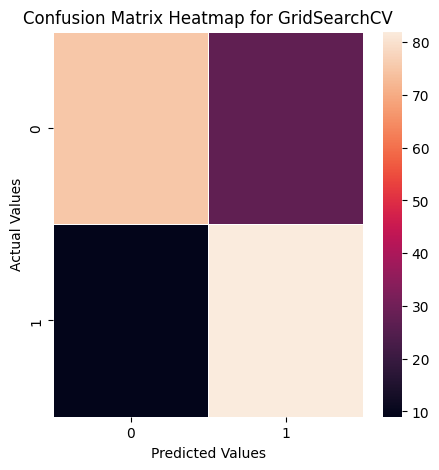

{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
0.8787106446776611


In [21]:
# Define a dictionary of hyperparameters for the grid search
param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [10, 25, 50, 100, 500]
}

# Define a default Random Forest model
estimator = RandomForestClassifier(random_state=0)

# Define the GridSearchCV model
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=True)

# Fit and evaluate the grid search model
clf = fit_and_eval(grid_search)[0]

# Output the best parameters and score found
print(grid_search.best_params_)
print(grid_search.best_score_)

Metrics for RandomForestClassifier:
Accuracy: 0.7875647668393783
Precision: 0.7232142857142857
Recall: 0.8901098901098901
F1 Score: 0.7980295566502463
ROC AUC Score: 0.7930941607412195
Mean CV Accuracy: 0.8857142857142858

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78       102
           1       0.72      0.89      0.80        91

    accuracy                           0.79       193
   macro avg       0.80      0.79      0.79       193
weighted avg       0.80      0.79      0.79       193



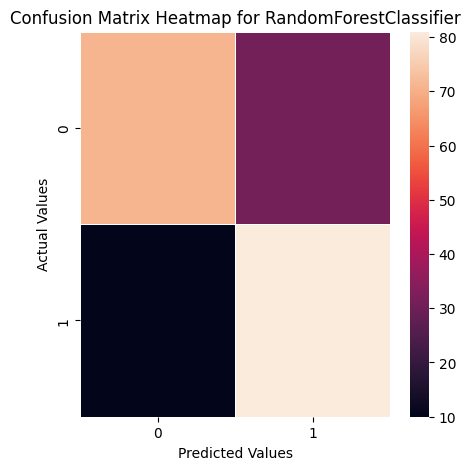

In [24]:
# Create a new Random Forest model with the fine-tuned hyperparameters
rfc = RandomForestClassifier(random_state=0, criterion='gini', max_depth=10, max_features='sqrt', n_estimators=500)

# Fit and evaluate the Random Forest model
clf = fit_and_eval(rfc)[0]

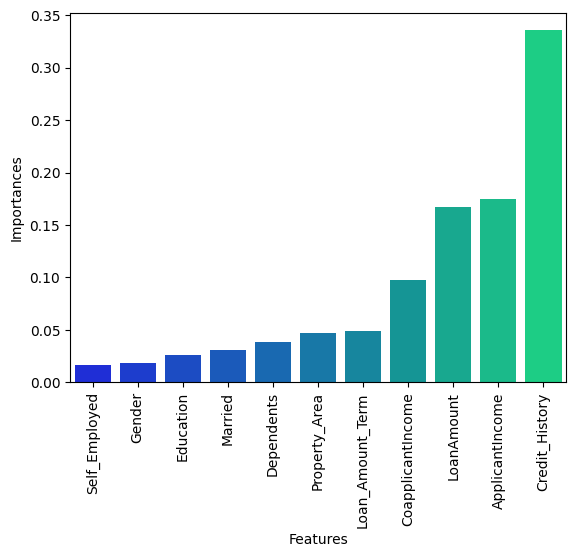

In [25]:
# Initialize the feature scores for the RFC model in a Pandas Series
feature_scores = pd.Series(clf.feature_importances_, index=df.columns[:11]).sort_values()

# Initialize the labels and values from the feature_scores Series
labels = feature_scores.index
values = feature_scores.values

# Visualize feature importances for the Random Forest Classifier model
sns.barplot(x=labels, y=values, palette='winter')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical') # rotate the tick labels on the x-axis
plt.show()

In [26]:
def validate_input(str, valid_inputs):
    
    user_input = input(str).lower()

    # Validate inputs where valid_inputs are a list of inputs
    if isinstance(valid_inputs, list):
        while user_input not in valid_inputs:
            print('Invalid response. Please try again.')
            user_input = input(str).lower()
    else: # Validate numeric inputs
        while not user_input.isnumeric() or int(user_input) < 0:
            print('Invalid response. Please try again.')
            user_input = input(str).lower()

    return user_input

In [27]:
# Collect user inputs
gender = validate_input('What is your gender? (M/F): ', ['m', 'f'])
married = validate_input('Are you married? (Y/N): ', ['y', 'n'])
dependents = validate_input('How many dependents do you have?: ', 0)
education = validate_input('Have you graduated high school? (Y/N): ', ['y', 'n'])
self_employed = validate_input('Are you self-employed? (Y/N): ', ['y', 'n'])
applicant_income = validate_input('What is your annual income?: ', 0)
co_applicant_income = validate_input('What is your co-applicant\'s annual income? (0 if N/A): ', 0)
loan_amount = validate_input('What is your desired loan amount? (e.g.: 150000): ', 0)
loan_terms = validate_input('What loan term (in months) are you requesting? (180 or 360): ', ['180', '360'])
credit_history = validate_input('Do you have a history of good credit? (Y/N): ', ['y', 'n'])
property_area = validate_input('What area is the property located in? (rural, semirural, urban): ', ['rural', 'semirural', 'urban'])

# Map categorical inputs to numerical values
gender = 0 if gender == 'f' else 1
married = 0 if married == 'n' else 1
education = 0 if education == 'n' else 1
self_employed = 0 if self_employed == 'n' else 1
credit_history = 0 if credit_history == 'n' else 1
property_area = 0 if property_area == 'rural' else 1 if property_area == 'semirural' else 2

# Change types of integer inputs collected as strings
dependents = int(dependents)
applicant_income = int(applicant_income)
co_applicant_income = int(co_applicant_income)
loan_amount = int(loan_amount)
loan_terms = int(loan_terms)

# Organize inputs into a list
user_inputs = [
    gender, married, dependents, education, self_employed, applicant_income,
    co_applicant_income, loan_amount, loan_terms, credit_history, property_area
]

# Reshape and scale the input data
user_inputs = np.array(user_inputs).reshape(1, -1)
user_inputs_scaled = scaler.transform(user_inputs)

# Make a prediction on the scaled input data
prediction = clf.predict(user_inputs_scaled)
prediction_prob = clf.predict_proba(user_inputs_scaled)
prediction_prob_percent = round(prediction_prob[0][1] * 100, 2)

eligibility = 'Eligible' if prediction == 1 else 'NOT Eligibile'

# Output the eligibility determination
print('\nLoan Eligibility Determination: {} ({}%)'.format(eligibility, prediction_prob_percent))

What is your gender? (M/F): m
Are you married? (Y/N): y
How many dependents do you have?: 1
Have you graduated high school? (Y/N): y
Are you self-employed? (Y/N): y
What is your annual income?: 10000
What is your co-applicant's annual income? (0 if N/A): 0
What is your desired loan amount? (e.g.: 150000): 20000
What loan term (in months) are you requesting? (180 or 360): 180
Do you have a history of good credit? (Y/N): Y
What area is the property located in? (rural, semirural, urban): urban

Loan Eligibility Determination: Eligible (61.57%)
